In [5]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt

today = str(datetime.now().date())
plots_folder = f"./plots/{today}/iss"
os.system(f"mkdir -p {plots_folder}")

import sys
sys.path.append("../")
from utils import getVariables

In [6]:
from benfordslaw import benfordslaw

def bflaw_test(df: pd.DataFrame,
               cat_name: str = "all",
               alpha: float = 0.05,
               pos: int = 1,
               categories = ["no_vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut", "booster"],
               method="chi2"
              ):

    bl = benfordslaw(alpha=alpha,
                 pos=pos,
                 verbose=0,
                 method=method)

    
    X = []
    for c in categories:
        if cat_name != "all" and c != cat_name:
            continue
        X += df[c].tolist()
    
    X = np.array(X)
    
    # We do this because we are dealing with counts (only integers)
    if pos == 2:
        X = X[X > 9]
        
    print(f"Length X: {len(X)}")

    results = bl.fit(X)
    digits = np.array(results["percentage_emp"][:,0])
    obs = np.array(results["percentage_emp"][:,1])
    exp = np.array(bl.leading_digits)
    chi2 = np.round(results["t"],2)
    
    plt.figure(figsize=(10,5),dpi=90)
    plt.bar(digits, obs, width=0.5, label="Observed")
    plt.plot(digits, exp, "-o", color="r", markersize=9, label="Expected Benford")
    plt.xticks(digits)
    plt.grid()
    p_value = np.round(results["P"],2)
    
    if p_value <= bl.alpha:
        anomaly_str = " Anomaly detected!"
    else:
        anomaly_str = ""
        
    title = f"Benford's law test ISS data,"
    if cat_name != "all":
        title += f" ({cat_name})"
    title += f" position={pos}, chi2={chi2}, P={p_value} {anomaly_str}"
    title = title.replace("_"," ").replace('gt','>').replace('lt', '<')
    plt.title(title, fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.ylabel("Observed frequency [%]", fontsize=14)
    plt.savefig(f"{plots_folder}/bflawtest_pos{pos}_{cat_name}.png", bbox_inches="tight")
    return X

### Get data

In [7]:
df_ti = pd.read_csv("./data/rapporti_ISS - TI.csv")
df_decessi = pd.read_csv("./data/rapporti_ISS - Decessi.csv")
df_ricoveri = pd.read_csv("./data/rapporti_ISS - Ricoveri.csv")
df_contagi = pd.read_csv("./data/rapporti_ISS - Contagi.csv")

In [8]:
df_dict = {
    "contagi": df_contagi,
    "ricoveri": df_ricoveri,
    "terapie_intensive": df_ti, 
    "decessi": df_decessi
}

for d in df_dict.items():
    d[1]["split"] = d[0]

### Create single dataframe

In [9]:
df_iss = pd.concat(df_dict.values()).reset_index(drop=True)

Length X: 1520


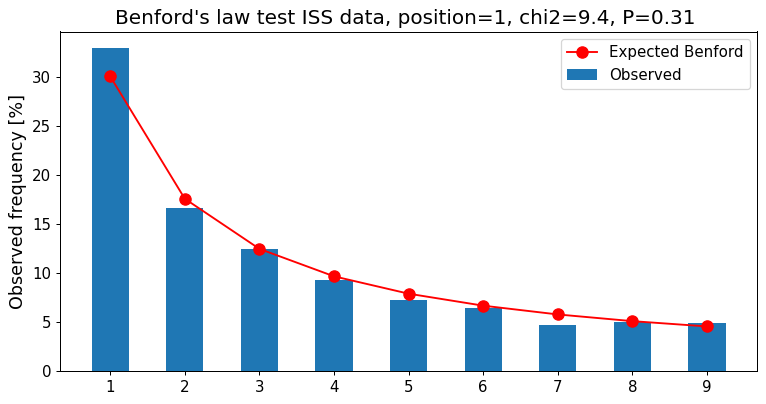

In [10]:
_ = bflaw_test(df_iss[df_iss.fascia_eta != "totale"], pos=1)

Length X: 1635


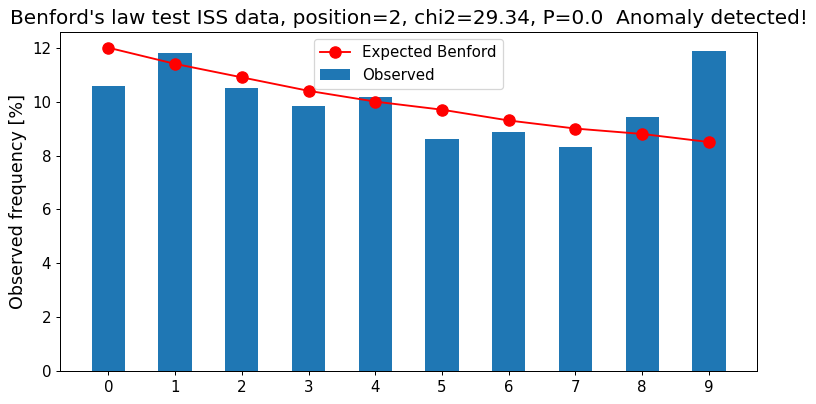

In [11]:
_ = bflaw_test(df_iss, pos=2)

### Bollettino giornaliero

In [8]:
df_daily_path = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df_daily = pd.read_csv(df_daily_path)

In [17]:
df_daily = getVariables(df_daily)

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df_daily.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido', 'dow', 'nuovi_positivi_lag_7',
       'ingressi_terapia_intensiva_lag_7', 'giorno',
       'nuovi_positivi_test_molecolare', 'nuovi_positivi_test_rapido',
       'variazione_deceduti', 'variazione_positivi',
       'variazione_relativa_positivi', 'variazione_deceduti_media_7',
       'ingressi_terapia_intensiva_30', 'variazione_guariti',
       'variazione_ospedalizzati', 'variazione_ricoverati_con_sintomi',
       'variazio

Length X: 691


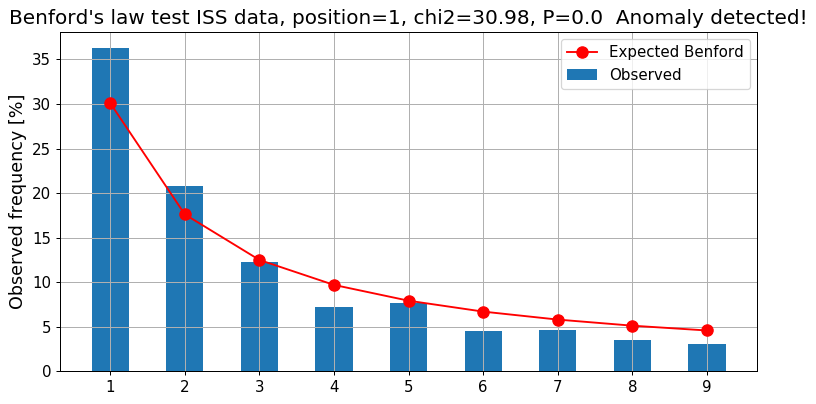

In [34]:
_ = bflaw_test(df_daily, pos=1, 
               categories=["nuovi_positivi"],
               method="chi2"
              )